In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [54]:
# Load the dataset
df=pd.read_csv('train.csv')

In [55]:
#df= df[df['SalePrice'] < 600000]


In [ ]:
correlation_matrix = df.corr(numeric_only=True)
correlation_with_target = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)
print(correlation_with_target.head(25))  # Top 25 features


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
KitchenAbvGr    0.135907
Name: SalePrice, dtype: float64


In [75]:
selected_features = df[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
                        '1stFlrSF', 'FullBath', 'YearBuilt',
                        'TotRmsAbvGrd', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea','LotFrontage',
                        'LotArea', 'GarageArea', 'BsmtQual', 'BsmtFinSF1', 'BsmtFinSF2','2ndFlrSF','GarageYrBlt',
                        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea']]
Y = df['SalePrice']


In [170]:
selected_features['Grlivarea2']=selected_features['GrLivArea']**2
selected_features['GerageCars2']=selected_features['GarageCars']**2



In [171]:
def one_hot_encode_df(df):
    return pd.get_dummies(df, drop_first=True) 


In [172]:
selected_features= one_hot_encode_df(selected_features)

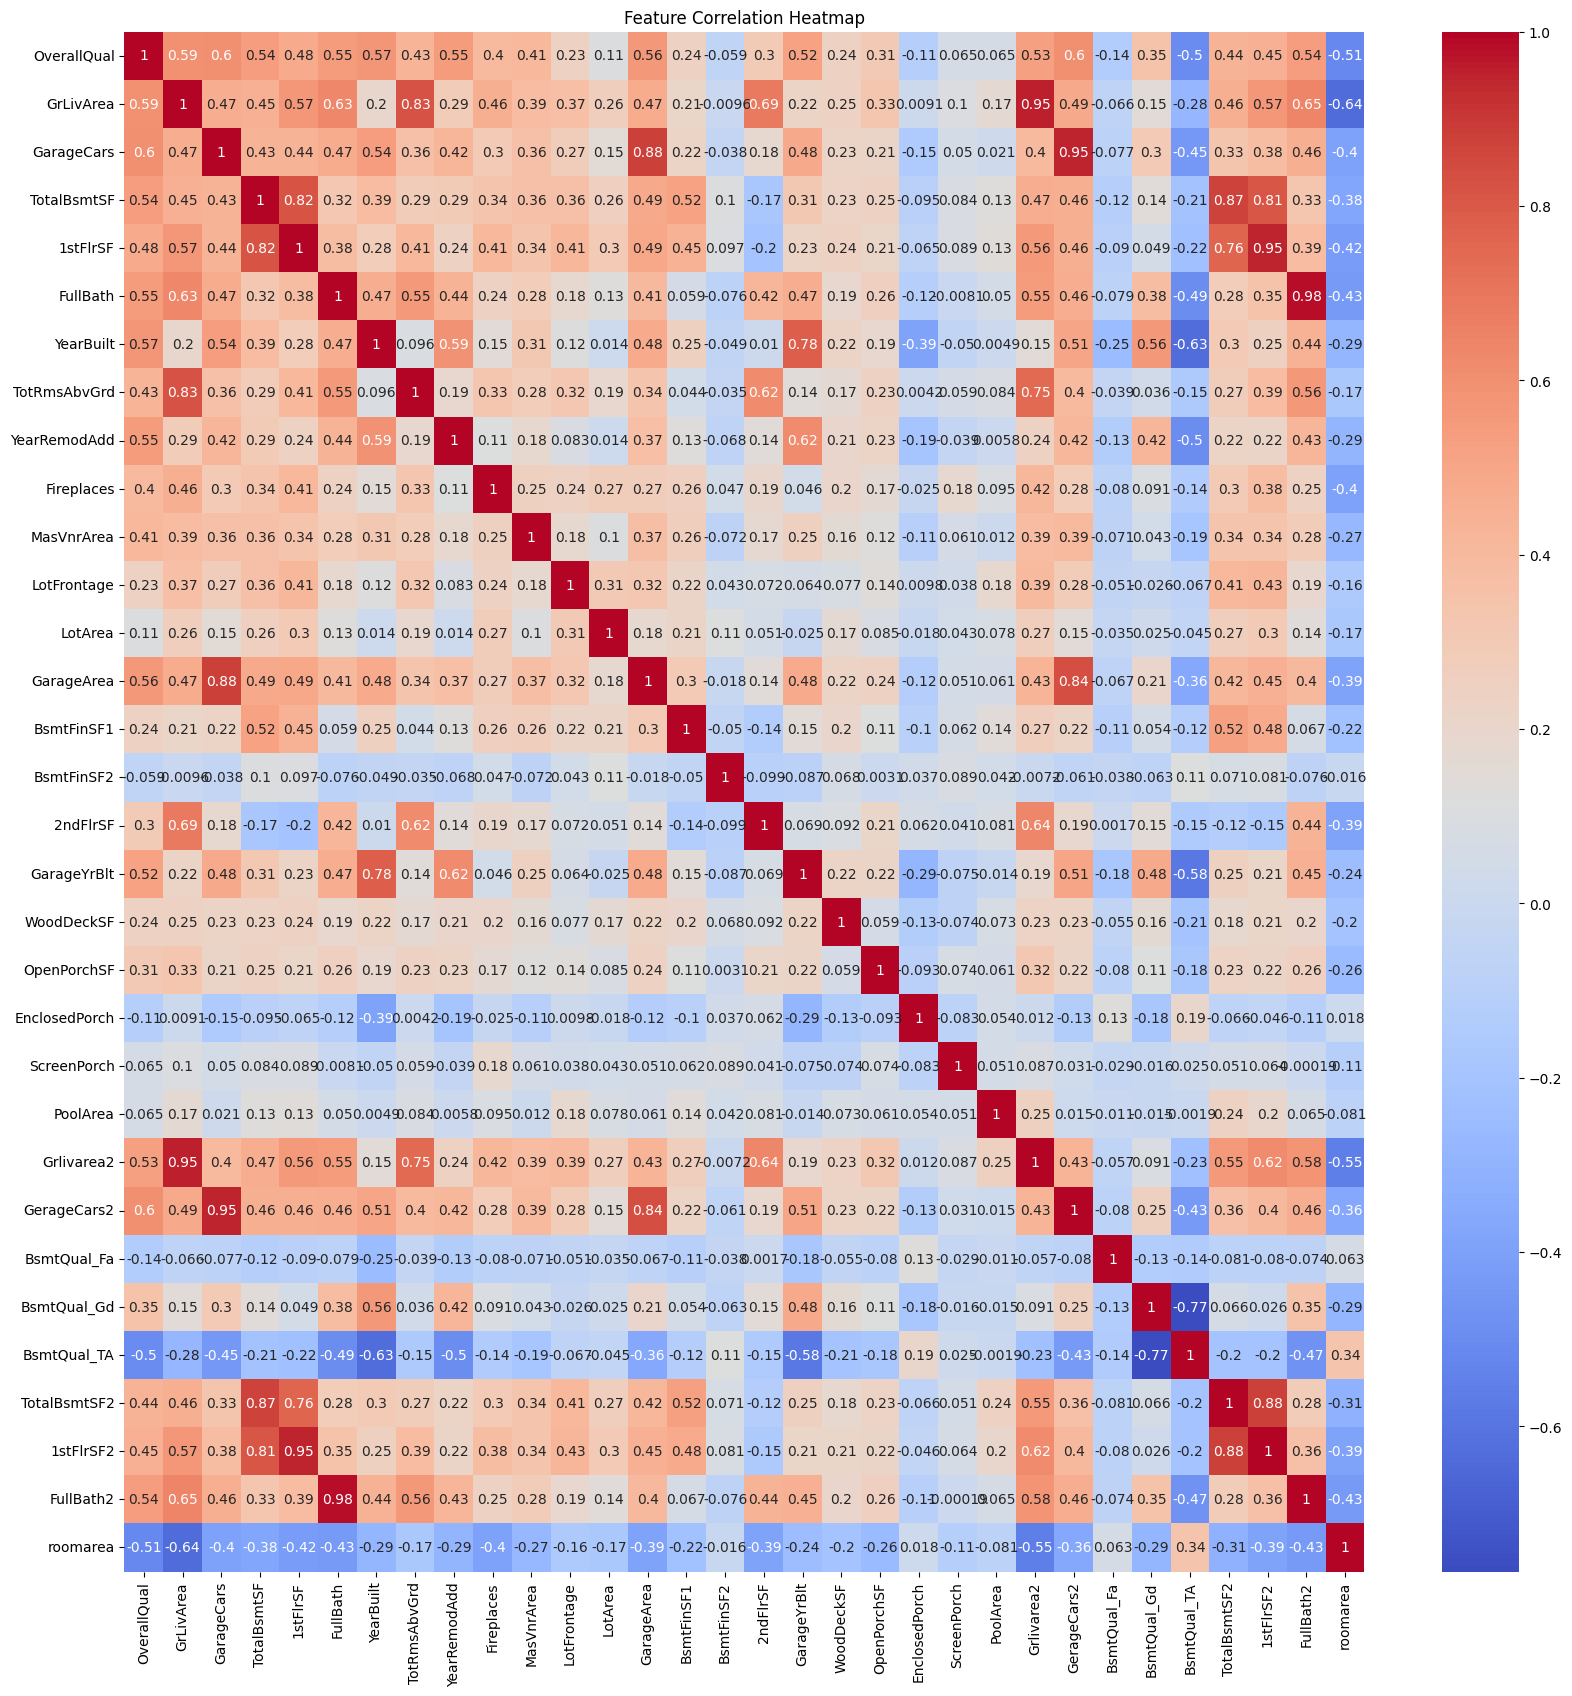

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = selected_features.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [174]:
selected_features.isnull().values.any()
# Fill missing values with the mean of each column
selected_features.fillna(selected_features.mean(), inplace=True)

In [175]:
X=selected_features

In [176]:
def feature_scaling(X_train, X_test):
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    for col in X_train.columns:
        mean = X_train[col].mean()
        std = X_train[col].std()
        X_train_scaled[col] = (X_train[col] - mean) / (std + 1e-8)
        X_test_scaled[col] = (X_test[col] - mean) / (std + 1e-8)  
    return X_train_scaled, X_test_scaled

In [177]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

y_train_log = np.log1p(y_train)  
y_test_log = np.log1p(y_test)


In [178]:
X_train_scaled, X_test_scaled = feature_scaling(X_train, X_test)

In [179]:
#for training Data
X_b=np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
# for testing data
X_b_test=np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))
#for weights and bias
theta=np.zeros(X_b.shape[1])

In [180]:
#predictions:
def predict(X, theta):
    return np.dot(X, theta)

In [181]:
#compute
def compute_cost(X,Y,theta):
    n=len(Y)
    prediction=predict(X, theta)
    cost = (1/(2*n)) * np.sum((prediction - Y) ** 2)
    return cost



In [182]:
def GradientDescent(X,Y,theta,learning_rate,epochs):
    n=len(Y)
    cost_history=[]
    for epoch in range(epochs):
        predictions=predict(X,theta)
        errors=predictions-Y
        gradient=(1/n) * np.dot(X.T, errors)
        theta-=learning_rate * gradient
        cost=compute_cost(X, Y, theta)
        cost_history.append(cost)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Cost: {cost:.10f}')
    return theta, cost_history

In [183]:
learning_rate = 0.01
epochs = 1000
theta_final, cost_history = GradientDescent(X_b, y_train_log, theta, learning_rate, epochs)

Epoch 0, Cost: 70.9935678988
Epoch 100, Cost: 9.5160058048
Epoch 200, Cost: 1.2845116034
Epoch 300, Cost: 0.1810928832
Epoch 400, Cost: 0.0329231424
Epoch 500, Cost: 0.0128630214
Epoch 600, Cost: 0.0100388184
Epoch 700, Cost: 0.0095671130
Epoch 800, Cost: 0.0094377175
Epoch 900, Cost: 0.0093717987


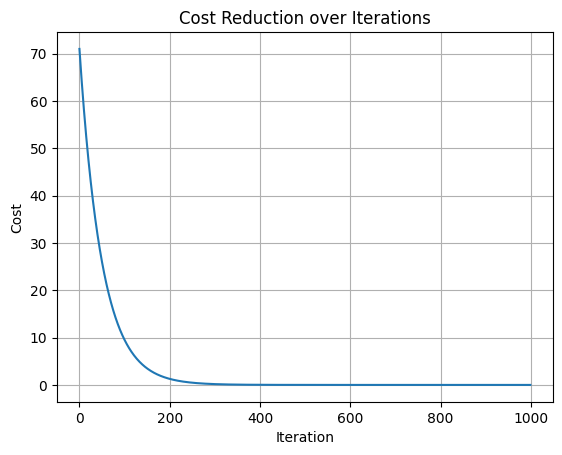

In [184]:
plt.plot(cost_history)
plt.title("Cost Reduction over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


In [185]:
y_pred_log = predict(X_b_test, theta_final)
predictions = np.expm1(y_pred_log)  # reverse the log transform

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print(f"Test MSE: {mse}")

print(f"Test RMSE: {rmse}")
print(f"Test R²: {r2}")



Test MSE: 987154597.9011225
Test RMSE: 31419.016501175247
Test R²: 0.871302136149548


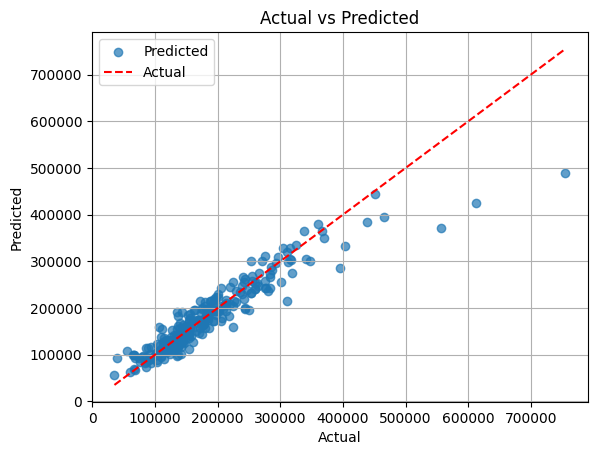

In [186]:
plt.scatter(y_test, predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.legend(['Predicted', 'Actual'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()


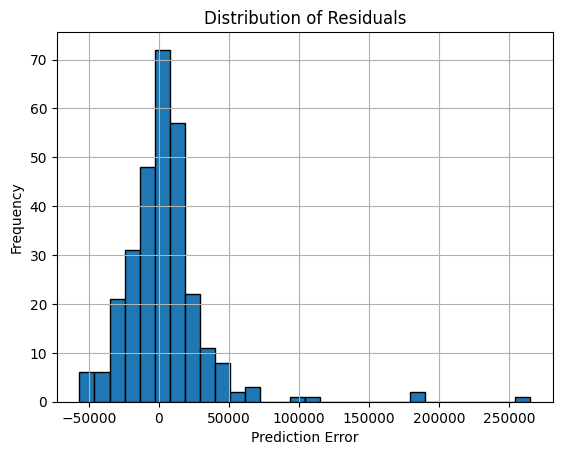

In [187]:
residuals = y_test - predictions
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()